In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import rasterio.features
import rasterio.warp
import rasterio.plot
import rasterio.mask
from pyproj import CRS, Proj
from shapely.geometry import Polygon, box
from shapely.geometry import mapping as geojson_mapping
import fiona
from descartes import PolygonPatch
from matplotlib import collections as cplt
import matplotlib.pyplot as plt
%matplotlib inline

## Reading data

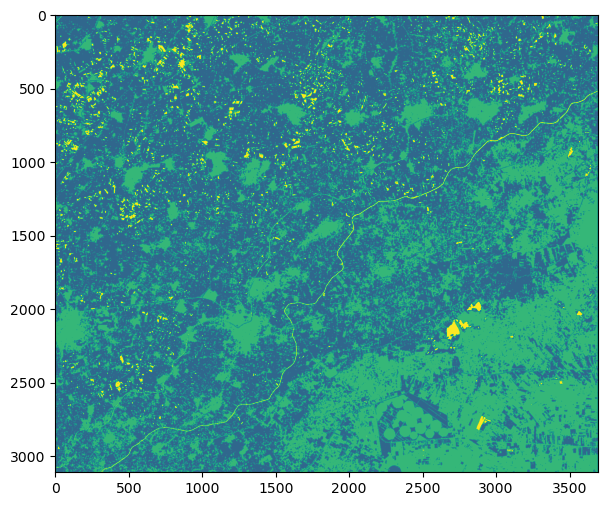

In [2]:
# Open Faqus raster map classified to agriculture, buildings, water bodies and unclassified
faq_cls = rasterio.open("images/Faqus_Classified.tif")
plt.figure(figsize=(7,7))
plt.imshow(faq_cls.read(1), cmap = 'viridis')
plt.show()

In [3]:
# Extracts the GeoJSON shapes of a raster’s valid data footprint.
with rasterio.open('images/Faqus_Classified.tif') as dataset:
    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=6)
        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[31.659777, 30.918505], [31.663662, 30.63795], [32.048878, 30.641339], [32.046112, 30.921932], [31.659777, 30.918505]]]}


In [4]:
# Claculate the bounds and geometry
# Transform is the affine transformation matrix that maps pixel locations in (col, row) coordinates to (x, y) spatial positions.
faq_href = "images/Faqus_Classified.tif"
with rasterio.open(faq_href) as dataset:
    fac_bbox = list(dataset.bounds)
    fac_transform = list(dataset.transform)
    fac_shape = [dataset.height, dataset.width]
    
    transformer = Proj.from_crs(CRS.from_epsg(4326),
                                CRS.from_epsg(4326),
                                always_xy=True)
    bbox = list(
        transformer.transform_bounds(dataset.bounds.left,
                                     dataset.bounds.bottom,
                                     dataset.bounds.right,
                                     dataset.bounds.top))
    geometry = geojson_mapping(box(*bbox, ccw=True))

In [5]:
print('fac_bbox: ', fac_bbox, '\n')
print('fac_transform: ', fac_transform, '\n')
print('fac_shape: ', fac_shape, '\n')
print('transformer: ', transformer, '\n')
print('bbox: ', bbox, '\n')
print('geometry: ', geometry)

fac_bbox:  [371940.0, 3390240.0, 408860.0, 3421340.0] 

fac_transform:  [10.0, 0.0, 371940.0, 0.0, -10.0, 3421340.0, 0.0, 0.0, 1.0] 

fac_shape:  [3110, 3692] 

transformer:  proj=noop ellps=GRS80 

bbox:  [371940.0, 3390240.0, 408860.0, 3421340.0] 

geometry:  {'type': 'Polygon', 'coordinates': (((408860.0, 3390240.0), (408860.0, 3421340.0), (371940.0, 3421340.0), (371940.0, 3390240.0), (408860.0, 3390240.0)),)}


In [6]:
# The product of this matrix and (0, 0), the column and row coordinates of the upper left corner of the dataset.
faq_cls.transform * (0, 0)

(371940.0, 3421340.0)

In [7]:
# The position of the lower right corner is obtained similarly
faq_cls.transform * (faq_cls.width, faq_cls.height)

(408860.0, 3390240.0)

In [8]:
# To get the coordinates of the center of the image.
faq_cls.xy(faq_cls.height // 2, faq_cls.width // 2)

(390405.0, 3405785.0)

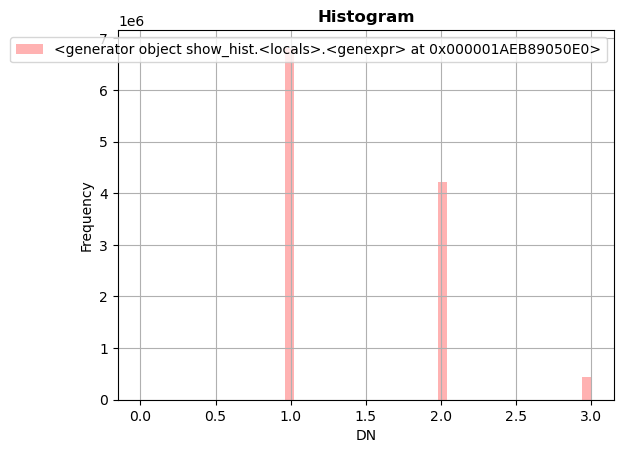

In [9]:
# Show the histogram of the raster image data
rasterio.plot.show_hist(faq_cls, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

Present the data of raster image in a dataframe

In [10]:
# Display the data in raster image
faq_band = faq_cls.read(1)
faq_band

array([[1, 1, 1, ..., 2, 2, 0],
       [1, 1, 1, ..., 2, 2, 0],
       [1, 1, 1, ..., 1, 2, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 0],
       [2, 2, 1, ..., 2, 2, 0],
       [2, 1, 1, ..., 2, 2, 0]], dtype=int16)

In [11]:
# Save the raster image data in a np array
faq_imarray = np.array(faq_band)
faq_imarray.shape

(3110, 3692)

In [12]:
faq_imarray

array([[1, 1, 1, ..., 2, 2, 0],
       [1, 1, 1, ..., 2, 2, 0],
       [1, 1, 1, ..., 1, 2, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 0],
       [2, 2, 1, ..., 2, 2, 0],
       [2, 1, 1, ..., 2, 2, 0]], dtype=int16)

In [13]:
# Convert it to 1D arary
flat_array =  np.ndarray.flatten(faq_imarray)
flat_array

array([1, 1, 1, ..., 2, 2, 0], dtype=int16)

In [14]:
def clas_array(im_arr):
    new_arr = []
    for i in im_arr:
        if i == 1:
            new_arr.append('Agriculture')
        elif i == 2:
            new_arr.append('Buildings')
        elif i == 3:
            new_arr.append('Water bodies')
        else:
            new_arr.append('Unclassified')
    return new_arr

In [15]:
imarray_f = clas_array(flat_array)

In [16]:
imdict = {'Id': flat_array, 'Name': imarray_f}
df = pd.DataFrame(imdict)
df.head()

,Id,Name
0,1,Agriculture
1,1,Agriculture
2,1,Agriculture
3,1,Agriculture
4,1,Agriculture


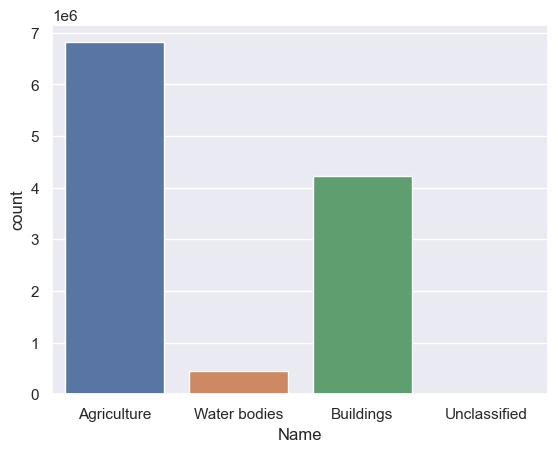

In [17]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Name", data=df)

In [18]:
df[df['Id'] == 1].count()

Id      6818112
Name    6818112
dtype: int64

In [19]:
df_agr = df.loc[df['Id'] == 1].count()
agr = df_agr['Id']
agr

6818112

## Masking a raster using a shapefile
Using rasterio with fiona, it is simple to open a shapefile, read geometries, and mask out regions of a raster that
are outside the polygons defined in the shapefile

In [20]:
with fiona.open("images/faqus_layer.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

In [21]:
with rasterio.open("images/Faqus_Classified.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

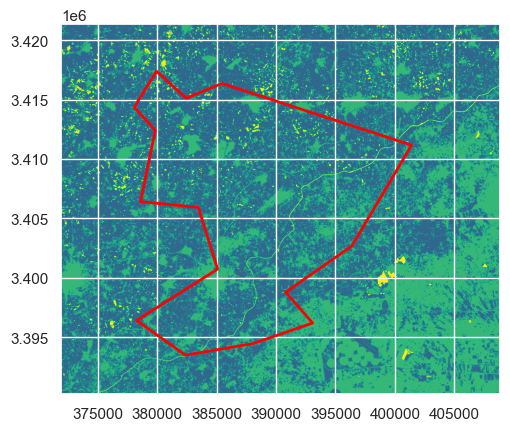

In [22]:
with rasterio.open("images/Faqus_Classified.tif") as src:
    fig, ax = plt.subplots()
    rasterio.plot.show((src, 1), ax=ax, cmap='viridis')
    patches = [PolygonPatch(feature, edgecolor="red", facecolor="none", linewidth=2) for feature in features]
    ax.add_collection(cplt.PatchCollection(patches, match_original=True))
    plt.show()

In [23]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_faq.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

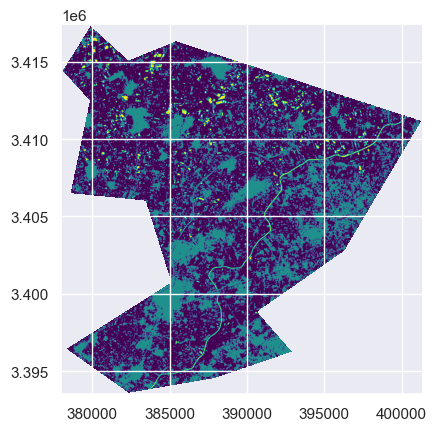

<Axes: >

In [24]:
# Plot the masked file
mas_faq = rasterio.open("images/masked_faq.tif")
rasterio.plot.show((mas_faq), cmap = 'viridis')

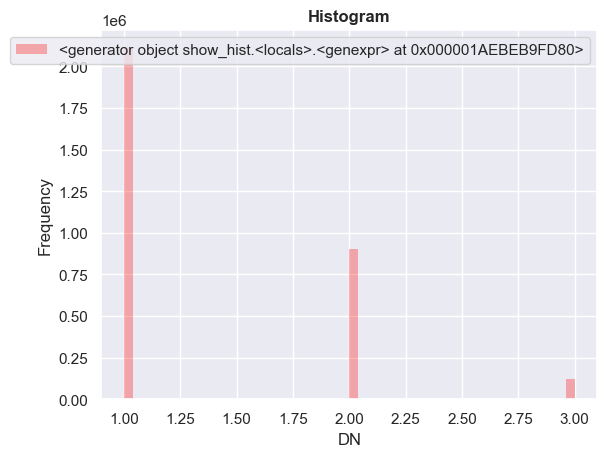

In [26]:
# Show the histogram of the masked file data
rasterio.plot.show_hist(mas_faq, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

Present the data of the masked raster image in a dataframe

In [27]:
# Display the data in raster image
band_mas = mas_faq.read(1)
band_mas

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

In [28]:
# Save the raster image data in a np array
mas_imarray = np.array(band_mas)
mas_imarray.shape

(2390, 2335)

In [29]:
mas_imarray

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

In [30]:
# Convert it to 1D arary
flat_array1 =  np.ndarray.flatten(mas_imarray)
flat_array1

array([-32768, -32768, -32768, ..., -32768, -32768, -32768], dtype=int16)

In [31]:
imarray_m = clas_array(flat_array1)

In [32]:
imdict = {'Id': flat_array1, 'Name': imarray_m}
df_m = pd.DataFrame(imdict)
df_m.head()

,Id,Name
0,-32768,Unclassified
1,-32768,Unclassified
2,-32768,Unclassified
3,-32768,Unclassified
4,-32768,Unclassified


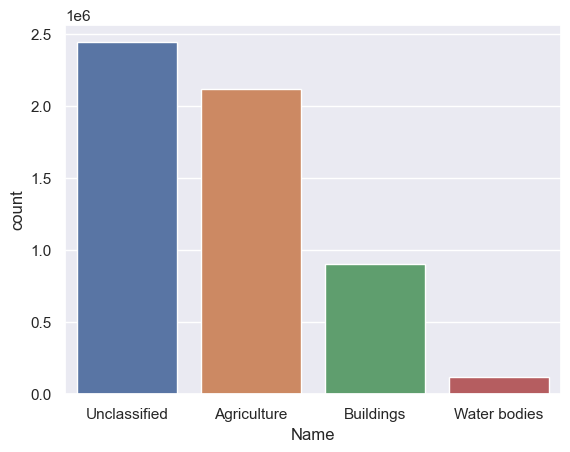

In [33]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Name", data=df_m)

In [34]:
df_m[df_m['Id'] == 1].count()

Id      2115246
Name    2115246
dtype: int64

In [35]:
dfm_agr = df_m.loc[df['Id'] == 1].count()
agrm = dfm_agr['Id']
agrm

3906769

In [47]:
print("Agriculture by the unmasked image: ", agr)
print("Agriculture by the masked image: ", agrm)

Agriculture by the unmasked image:  6818112
Agriculture by the masked image:  3906769


#### Difference between 2 raster images

In [37]:
# Coordinate Reference System
print(faq_cls.crs)
print(mas_faq.crs)

EPSG:32636
EPSG:32636


In [41]:
print("Unmasked image: ", faq_cls.transform)
print("Masked image: ", mas_faq.transform)

Unmasked image:  | 10.00, 0.00, 371940.00|
| 0.00,-10.00, 3421340.00|
| 0.00, 0.00, 1.00|
Masked image:  | 10.00, 0.00, 378010.00|
| 0.00,-10.00, 3417430.00|
| 0.00, 0.00, 1.00|


In [42]:
print(faq_cls.shape)
print(mas_faq.shape)

(3110, 3692)
(2390, 2335)
